# Content-Based Filtering Recommendation System with Clustering 

This project is an exploration of applying the clustering method to the Content-based Filtering recommendation system, based on the concepts and methods introduced in the course 23/24 Personalisation and Machine Learning at UAL CCI led by Louis McCallum, Marysia Tańska and Marissa Beaty. Some codes are inspired from the 'Week 3: Content Based Filtering' course notebook.

If you started this project with the version without clustering operations, you can read from the 'Clustering the tags' section directly as all the previous sections are the same.


In [62]:
# import libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity as cosine
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:,.2f}'.format

np.set_printoptions(threshold=np.inf)

## Setup the dataset

In [63]:
# the dataset is accessed from https://www.kaggle.com/datasets/nikdavis/steam-store-games

chunks = pd.read_csv("data/steam.csv", chunksize=1024, index_col=0)
games = pd.DataFrame()

for chunk in chunks:
    games = pd.concat([games, chunk])
games

,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
appid,,,,,,,,,,,,,,,,,
10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065230,Room of Pandora,2019-04-24,1,SHEN JIAWEI,SHEN JIAWEI,windows,0,Single-player;Steam Achievements,Adventure;Casual;Indie,Adventure;Indie;Casual,7,3,0,0,0,0-20000,2.09
1065570,Cyber Gun,2019-04-23,1,Semyon Maximov,BekkerDev Studio,windows,0,Single-player,Action;Adventure;Indie,Action;Indie;Adventure,0,8,1,0,0,0-20000,1.69
1065650,Super Star Blast,2019-04-24,1,EntwicklerX,EntwicklerX,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,Action;Indie;Casual,24,0,1,0,0,0-20000,3.99


In [64]:
# the data is too large and my laptop was having memory space issues, so we only use the first 4000 rows for this project
games = games.head(4000)

# drop columns that are not needed to save memory space
games = games.drop(['english', 'developer', 'required_age',
                   'median_playtime', 'owners'], axis=1)

# only keep the year of the release date
games['release_year'] = games['release_date'].str.split('-').str[0]
games['release_year'] = games['release_year'].astype(int)

games.drop(columns=['release_date'], inplace=True)
games = games.dropna()  # drop rows with missing values

# from the count we know that 1 game has missing values in any of the columns we are interested in
games.describe()

,achievements,positive_ratings,negative_ratings,average_playtime,price,release_year
count,"3,999.00","3,999.00","3,999.00","3,999.00","3,999.00","3,999.00"
mean,23.51,"4,585.21",771.84,427.90,8.30,"2,012.71"
std,60.78,"47,884.81","7,581.66","2,580.30",7.07,2.65
min,0.00,0.00,0.00,0.00,0.00,"1,997.00"
25%,0.00,71.00,31.00,0.00,3.99,"2,011.00"
50%,12.00,280.00,93.00,24.00,6.99,"2,014.00"
75%,31.00,"1,345.50",303.00,256.00,10.99,"2,014.00"
max,"1,746.00","2,644,404.00","402,313.00","95,245.00",95.99,"2,019.00"


## Encode the textual features first


In [65]:
# check the dara types of the columns before encoding
print(games.dtypes)

name                 object
publisher            object
platforms            object
categories           object
genres               object
steamspy_tags        object
achievements          int64
positive_ratings      int64
negative_ratings      int64
average_playtime      int64
price               float64
release_year          int32
dtype: object


Before heading to the encoding steps, let's have a check on the numbers of the unique values:

In [66]:
columns_to_inspect = ['publisher', 'platforms',
                      'categories', 'genres', 'steamspy_tags']

# use a copy of the data here to avoid modifying the original data
df_check_only = games.copy()

# split the strings in the columns by the semicolon and then explode them into individual rows
for column in columns_to_inspect:
    df_check_only[column] = df_check_only[column].str.split(';')
    df_check_only = df_check_only.explode(column)

# calculate the number of unique values in each column
unique_values_counts = df_check_only[columns_to_inspect].nunique()
print(unique_values_counts)

publisher        1623
platforms           3
categories         29
genres             26
steamspy_tags     272
dtype: int64


Since there are too many unique values for 'publisher' and 'steamspy_tags' columns, using one hot encoding will lead to 'the curse of dimensionality' and increase computation, so other methods are used to deal with it subsequently.

Let's set up a function that splits and one-hot encodes multi-element columns, and call it to the columns that need to be applied in turn.

In [67]:
# the function takes the dataframe, the columns to split, the separator and the prefix for the new columns
def multi_one_hot(df, column_to_split, separate_by, col_prefix):

    # split the column by the separator
    df[column_to_split] = df[column_to_split].str.split(separate_by)

    # explode the column to have one element per row
    df_exploded = df.explode(column_to_split)

    # one-hot encode the columns
    df_encoded = pd.get_dummies(df_exploded, columns=[column_to_split])

    # get the names of the columns that were added
    added_columns = []
    for col in df_encoded.columns:
        if col.startswith(col_prefix):
            added_columns.append(col)

    # sum only the one-hot encoded columns and group by game name
    grouped = df_encoded.groupby('name')[added_columns].sum()

    # reset the index and set the game name as the index
    grouped = grouped.reset_index()
    grouped.set_index('name', inplace=True)

    return grouped


# save the one-hot encoded columns in a list
encoded_multi_columns = []

In [68]:
multi_columns_to_encode = ['platforms', 'categories', 'genres']

for column in multi_columns_to_encode:
    # copy the dataframe to make sure everytime the fucntion only works on the original data
    encoded_multi_column = multi_one_hot(
        games.copy(), column, ';', column + '_')
    encoded_multi_columns.append(encoded_multi_column)

In [69]:
one_hot_df = pd.concat(encoded_multi_columns, axis=1)

one_hot_df.set_index(games['name'], inplace=True)
one_hot_df

,platforms_linux,platforms_mac,platforms_windows,categories_Captions available,categories_Co-op,categories_Commentary available,categories_Cross-Platform Multiplayer,categories_Full controller support,categories_In-App Purchases,categories_Includes Source SDK,...,genres_Racing,genres_Sexual Content,genres_Simulation,genres_Software Training,genres_Sports,genres_Strategy,genres_Utilities,genres_Video Production,genres_Violent,genres_Web Publishing
name,,,,,,,,,,,,,,,,,,,,,
Counter-Strike,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Team Fortress Classic,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Day of Defeat,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Deathmatch Classic,0,1,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Half-Life: Opposing Force,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FEIST,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Gloria Victis,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Out of Reach,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Since the 'publisher' column contains many unique values, while the frequency of the values maymatters (the size of the game publisher may be an important feature for game recommendations), the 'importance' of the word can be calculated by using TFIDF encoding.

In [70]:
copy1 = games.copy()
columns_to_tfidf = ['publisher']

# initiate an empty DataFrame to store all the encoded columns
tfidf_df = pd.DataFrame(index=one_hot_df.index)

# do TF-IDF encoding to the column(s) and combine them into one daraframe
for column in columns_to_tfidf:
    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(copy1[column])
    tfidf_df_temp = pd.DataFrame(tfidf_matrix.toarray(
    ), columns=tfidf.get_feature_names_out(), index=one_hot_df.index)
    tfidf_df = pd.concat([tfidf_df, tfidf_df_temp], axis=1)

tfidf_df

,101,10tons,11,17,1c,244,2d,2dengine,2k,2play,...,zero,zeroscale,zojoi,zombie,zoo,zooloretto,zooptek,zotnip,zueira,zut
name,,,,,,,,,,,,,,,,,,,,,
Counter-Strike,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Team Fortress Classic,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Day of Defeat,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Deathmatch Classic,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Half-Life: Opposing Force,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FEIST,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Gloria Victis,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Out of Reach,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [71]:
# there are many new features after encoding - let's check the sparsity of the data
total_cells_tfidf = tfidf_df.size
non_zero_tfidf = tfidf_df.astype(bool).sum().sum()
percentage_non_zero_tfidf = (non_zero_tfidf / total_cells_tfidf) * 100
print(percentage_non_zero_tfidf, '%')

0.11446376238411068 %


In [72]:
# Very low sparsity, use PCA to downscale the data to keep only 95% of the variance
# https://stackoverflow.com/questions/76899048/how-to-obtain-specific-principal-components-from-pca-using-sklearn-or-matplotlib
pca = PCA(n_components=0.95)
tfidf_reduced = pca.fit_transform(tfidf_df)
tfidf_df = pd.DataFrame(tfidf_reduced, index=one_hot_df.index)

tfidf_df

,0,1,2,3,4,5,6,7,8,9,...,1152,1153,1154,1155,1156,1157,1158,1159,1160,1161
name,,,,,,,,,,,,,,,,,,,,,
Counter-Strike,-0.00,-0.00,-0.03,0.00,-0.02,0.01,0.03,0.04,-0.01,0.07,...,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00
Team Fortress Classic,-0.00,-0.00,-0.03,0.00,-0.02,0.01,0.03,0.04,-0.01,0.07,...,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00
Day of Defeat,-0.00,-0.00,-0.03,0.00,-0.02,0.01,0.03,0.04,-0.01,0.07,...,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00
Deathmatch Classic,-0.00,-0.00,-0.03,0.00,-0.02,0.01,0.03,0.04,-0.01,0.07,...,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00
Half-Life: Opposing Force,-0.00,-0.00,-0.03,0.00,-0.02,0.01,0.03,0.04,-0.01,0.07,...,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FEIST,-0.00,-0.00,-0.02,0.00,-0.01,0.00,0.02,0.02,-0.01,0.03,...,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00
Gloria Victis,-0.01,-0.02,-0.11,-0.01,-0.11,-0.17,-0.07,-0.06,-0.02,-0.05,...,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00
Out of Reach,-0.01,-0.03,-0.01,-0.00,-0.02,0.01,0.08,0.24,-0.01,-0.06,...,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00


For the 'steamspy_tags' column, since there is no comparative relationship (e.g. 'action' and 'shoot' are only used as game tags, there is no logical relationship between them) for the words, the Bag of Words method is good enough to encode them.

In [73]:
copy2 = games.copy()
columns_to_bow = ['steamspy_tags']

bow_df = pd.DataFrame(index=one_hot_df.index)

for column in columns_to_bow:
    copy2[column] = copy2[column].str.replace(';', ' ')
    count = CountVectorizer()
    count_matrix = count.fit_transform(copy2[column])
    bow_df_temp = pd.DataFrame(count_matrix.toarray(
    ), columns=count.get_feature_names_out(), index=one_hot_df.index)
    bow_df = pd.concat([bow_df, bow_df_temp], axis=1)

bow_df

,1980s,2d,3d,40k,4x,6dof,access,action,adventure,agriculture,...,wars,web,werewolves,western,with,workshop,world,wrestling,your,zombies
name,,,,,,,,,,,,,,,,,,,,,
Counter-Strike,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Team Fortress Classic,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Day of Defeat,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Deathmatch Classic,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Half-Life: Opposing Force,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FEIST,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Gloria Victis,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Out of Reach,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [74]:
# check the sparsity of the data
total_cells_bow = bow_df.size
non_zero_bow = bow_df.astype(bool).sum().sum()
percentage_non_zero_bow = (non_zero_bow / total_cells_bow) * 100
print(percentage_non_zero_bow, '%')

1.1078856670689412 %


In [75]:
# since the sparsity for the BoW data is also low, we will do PCA to it as well
pca = PCA(n_components=0.95)
bow_reduced = pca.fit_transform(bow_df)
bow_df = pd.DataFrame(bow_reduced, index=one_hot_df.index)

bow_df

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,102
name,,,,,,,,,,,,,,,,,,,,,
Counter-Strike,-0.31,0.87,-0.46,-0.07,-0.13,0.02,0.30,0.10,-0.21,0.02,...,-0.00,-0.01,-0.00,-0.01,0.02,0.00,0.02,-0.00,0.01,0.01
Team Fortress Classic,-0.31,0.87,-0.46,-0.07,-0.13,0.02,0.30,0.10,-0.21,0.02,...,-0.00,-0.01,-0.00,-0.01,0.02,0.00,0.02,-0.00,0.01,0.01
Day of Defeat,0.31,0.32,-0.53,-0.36,0.08,-0.28,0.14,1.19,0.60,0.24,...,-0.00,-0.01,-0.00,-0.10,-0.08,-0.01,0.02,0.02,0.01,0.02
Deathmatch Classic,-0.31,0.87,-0.46,-0.07,-0.13,0.02,0.30,0.10,-0.21,0.02,...,-0.00,-0.01,-0.00,-0.01,0.02,0.00,0.02,-0.00,0.01,0.01
Half-Life: Opposing Force,-0.30,0.86,-0.42,0.09,-0.29,0.13,0.04,0.13,-0.40,-0.08,...,0.00,-0.00,-0.00,0.01,-0.00,-0.01,0.01,0.00,0.00,-0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FEIST,-0.74,0.45,0.59,0.08,-0.06,-0.14,0.06,0.11,-0.14,-0.09,...,-0.02,0.01,-0.01,0.00,0.00,-0.00,0.00,-0.00,0.01,-0.00
Gloria Victis,0.23,0.08,-0.39,-0.42,0.30,-0.25,0.26,0.23,-0.10,-0.28,...,-0.02,0.01,-0.05,0.00,0.01,0.00,-0.03,-0.01,0.01,-0.02
Out of Reach,0.25,0.10,-0.44,-0.33,0.14,-0.17,-0.21,1.06,0.57,0.05,...,0.01,0.01,0.02,0.01,-0.03,-0.02,0.01,0.04,0.01,0.01


## Clustering the tags

If we look at the original data again, we can actually see that the 'steamspy_tags' column is having rich information, even containing the genres of the game sometimes. **If making the tags features have the highest weight when finding the similarity score between games by clustering the games based on their tags, can we have better results?**

c:\Users\tobys\miniconda3\envs\aim\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\tobys\miniconda3\envs\aim\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\tobys\miniconda3\envs\aim\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\tobys\miniconda3\envs\aim\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change fr

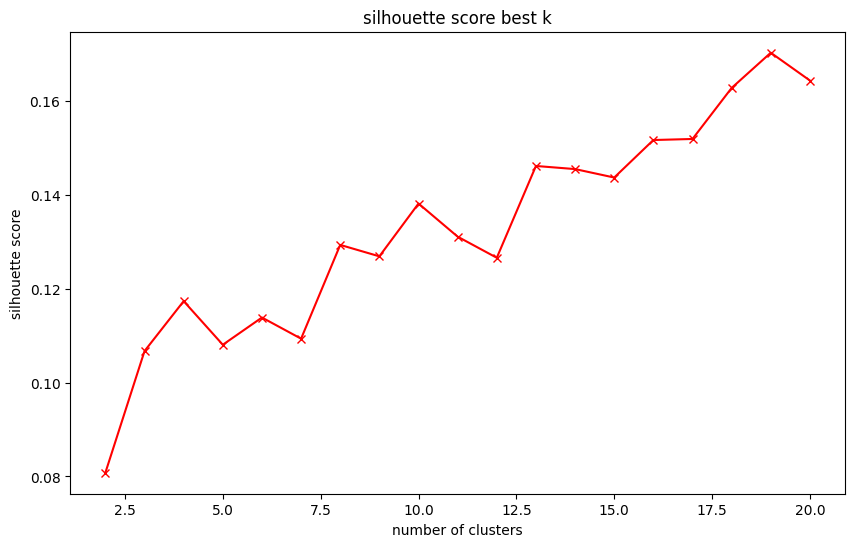

In [76]:
# find the best cluster number using the Silhouette Score (https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil_score = []
kMax = 20  # let's assume it will be up to 20 clusters

# calculate the silhouette score for different k values in our range given
for k in range(2, kMax+1):
    kmeans = KMeans(n_clusters=k, random_state=24).fit(bow_df)
    labels = kmeans.labels_
    sil_score.append(silhouette_score(bow_df, labels, metric='euclidean'))

# plot it
plt.figure(figsize=(10, 6))
plt.plot(range(2, kMax+1), sil_score, "-rx")
plt.xlabel("number of clusters")
plt.ylabel("silhouette score")
plt.title("silhouette score best k")
plt.show()

From the silhouette score plot we can see the best k falls on about 18/19 clusters, however, it is noticable the score is only about 0.18 even as the highest, which suggests that the current K-Means clustering result is not ideal. **Instead, let's try another clustering method: DBSCAN**, as shown below, maybe this one is more suitable in our test, considering DBSCAN can work well with datasets having noise and outliers than K-Means - which could be the case here!

In [77]:
# referenced from https://www.geeksforgeeks.org/dbscan-clustering-in-ml-density-based-clustering/

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# eps is the maximum distance between two samples for one to be considered as in the neighborhood of the other;
# min_samples is the number of samples in a neighborhood for a point to be considered as a cluster
# here we set it to 5 as we want each cluster to have at least 5 samples, for more accurate clustering
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(bow_df)
labels = dbscan.labels_

sil_score = silhouette_score(bow_df, labels)
print("DBSCAN Silhouette Score:", sil_score)

DBSCAN Silhouette Score: 0.32750691788921066


Although the DBSCAN silhouette score is also not too high (about 0.33), it suggested a better result than using K-Means, showing that this is a more suitable clustering method for the current case. It will be saved as another feature dataframe to be combined next.

In [78]:
# save the labels into a dataframe
labels_df = pd.DataFrame(labels, index=bow_df.index, columns=['cluster_label'])

## Encode all the numerical features


In [79]:
n_columns = ['release_year', 'achievements', 'positive_ratings',
             'negative_ratings', 'average_playtime', 'price']

subset_features = games[n_columns].dropna()
subset_features.describe()

,release_year,achievements,positive_ratings,negative_ratings,average_playtime,price
count,"3,999.00","3,999.00","3,999.00","3,999.00","3,999.00","3,999.00"
mean,"2,012.71",23.51,"4,585.21",771.84,427.90,8.30
std,2.65,60.78,"47,884.81","7,581.66","2,580.30",7.07
min,"1,997.00",0.00,0.00,0.00,0.00,0.00
25%,"2,011.00",0.00,71.00,31.00,0.00,3.99
50%,"2,014.00",12.00,280.00,93.00,24.00,6.99
75%,"2,014.00",31.00,"1,345.50",303.00,256.00,10.99
max,"2,019.00","1,746.00","2,644,404.00","402,313.00","95,245.00",95.99


In [80]:
# standardise and fit the data
scaled_features = StandardScaler().fit_transform(subset_features)

In [81]:
num_features_df = pd.DataFrame(
    scaled_features, columns=n_columns, index=one_hot_df.index)
num_features_df

,release_year,achievements,positive_ratings,negative_ratings,average_playtime,price
name,,,,,,
Counter-Strike,-4.80,-0.39,2.51,0.34,6.66,-0.16
Team Fortress Classic,-5.18,-0.39,-0.03,-0.02,-0.06,-0.61
Day of Defeat,-3.67,-0.39,-0.02,-0.05,-0.09,-0.61
Deathmatch Classic,-4.42,-0.39,-0.07,-0.07,-0.07,-0.61
Half-Life: Opposing Force,-5.18,-0.39,0.01,-0.06,0.08,-0.61
...,...,...,...,...,...,...
FEIST,0.87,0.27,-0.09,-0.09,-0.14,-0.19
Gloria Victis,1.24,0.37,-0.04,0.06,-0.02,0.95
Out of Reach,2.00,0.34,-0.06,0.02,0.17,0.38


## Combine Features

Now we have all the features encoded and ready to combine them as the final features matrix for the recommendation system! 

The dataset was processed to a 3999 rows x 1330 columns shape, containing only the encoded features, corresponding to 3999 games, 1330 features: **numeric features + one-hot encoded features + TF-IDF encoded features + BoW encoded features + the clustering labels**, minus the original columns that had been replaced. The game names are set as the indexes for reference.

In [82]:
# set the original dataframe to have the game name as the indices
games.set_index(one_hot_df.index, inplace=True)

# combine all the dataframes into one final dataframe
final_df = pd.concat([num_features_df,
                      one_hot_df,
                      tfidf_df,
                      bow_df, labels_df], axis=1)

final_df

,release_year,achievements,positive_ratings,negative_ratings,average_playtime,price,platforms_linux,platforms_mac,platforms_windows,categories_Captions available,...,94,95,96,97,98,99,100,101,102,cluster_label
name,,,,,,,,,,,,,,,,,,,,,
Counter-Strike,-4.80,-0.39,2.51,0.34,6.66,-0.16,0,0,1,0,...,-0.01,-0.00,-0.01,0.02,0.00,0.02,-0.00,0.01,0.01,0
Team Fortress Classic,-5.18,-0.39,-0.03,-0.02,-0.06,-0.61,0,0,1,0,...,-0.01,-0.00,-0.01,0.02,0.00,0.02,-0.00,0.01,0.01,0
Day of Defeat,-3.67,-0.39,-0.02,-0.05,-0.09,-0.61,0,0,1,0,...,-0.01,-0.00,-0.10,-0.08,-0.01,0.02,0.02,0.01,0.02,-1
Deathmatch Classic,-4.42,-0.39,-0.07,-0.07,-0.07,-0.61,0,1,1,0,...,-0.01,-0.00,-0.01,0.02,0.00,0.02,-0.00,0.01,0.01,0
Half-Life: Opposing Force,-5.18,-0.39,0.01,-0.06,0.08,-0.61,0,1,1,0,...,-0.00,-0.00,0.01,-0.00,-0.01,0.01,0.00,0.00,-0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FEIST,0.87,0.27,-0.09,-0.09,-0.14,-0.19,0,0,1,0,...,0.01,-0.01,0.00,0.00,-0.00,0.00,-0.00,0.01,-0.00,101
Gloria Victis,1.24,0.37,-0.04,0.06,-0.02,0.95,1,1,1,0,...,0.01,-0.05,0.00,0.01,0.00,-0.03,-0.01,0.01,-0.02,-1
Out of Reach,2.00,0.34,-0.06,0.02,0.17,0.38,0,0,1,0,...,0.01,0.02,0.01,-0.03,-0.02,0.01,0.04,0.01,0.01,-1


## Do the recommendation test

The function below will look at the cluster that the given game is in first, making sure the games recommeneded are at least having similar tags, since we set it as the most important feature to consider when calculating the similarities between games. 

This time will we get actual better recommendation results, than what we have seen in another system that without doing clustering on the game tags?

In [83]:
# define the recommendation as a function for easier access

def recommend_similar_games(game, recom_num):

    # get the features of the game
    game_features = final_df.loc[game].values.reshape(1, -1)

    # get the cluster lable of the game
    game_cluster = labels_df.loc[game, 'cluster_label']

    # find games from the same cluster according to the 'cluster_label' column and transform the data into a list
    same_cluster_games = final_df.index[labels_df['cluster_label'] == game_cluster].tolist(
    )
    same_cluster_games.remove(game)  # remove the game we defined from the list
    # get the features of these games
    same_cluster_features = final_df.loc[same_cluster_games].values

    # calculate the cosine similarity and recommend N most similar games
    similarity = cosine(game_features, same_cluster_features)
    # print(similarity)

    # .argsort() will sort the the similarity in ascending order, [-recom_num:] states to get N largest values (https://www.geeksforgeeks.org/numpy-argsort-in-python/ )
    top_similar_games = similarity.argsort()[0][-recom_num:]

    # get the recommended games list
    recommended_games = []
    for i in top_similar_games:
        game_name = same_cluster_games[i]
        similarity_score = similarity[0][i]*100
        recommended_games.append((game_name, similarity_score))

    # sort the games list of lists (https://stackoverflow.com/questions/4174941/how-to-sort-a-list-of-lists-by-a-specific-index-of-the-inner-list)
    recommended_games.sort(key=lambda x: x[1], reverse=True)
    # output as a DataFrame for a clear view
    recommended_df = pd.DataFrame(recommended_games, columns=[
                                  'Game', 'Similarity(%)'])

    return recommended_df

In [84]:
# let's have 10 recommendations for the classic game 'CS'
game = 'Counter-Strike'
recommended_games = recommend_similar_games(game, 10)
recommended_games

,Game,Similarity(%)
0,Counter-Strike: Source,82.32
1,Counter-Strike: Condition Zero,54.57
2,Ricochet,54.35
3,Team Fortress Classic,53.68
4,Half-Life 2: Deathmatch,50.24
5,Deathmatch Classic,49.35
6,Call of Duty® 4: Modern Warfare®,46.58
7,Homefront,45.48
8,Battlefield: Bad Company™ 2,39.83
9,Call of Duty®: Modern Warfare® 2,39.54


This time let's still look at the 4th most similar game to the given game, are they actually having more similar attributes in the profiles?

In [85]:
games.loc[game]

name                                                   Counter-Strike
publisher                                                       Valve
platforms                                           windows;mac;linux
categories          Multi-player;Online Multi-Player;Local Multi-P...
genres                                                         Action
steamspy_tags                                  Action;FPS;Multiplayer
achievements                                                        0
positive_ratings                                               124534
negative_ratings                                                 3339
average_playtime                                                17612
price                                                            7.19
release_year                                                     2000
Name: Counter-Strike, dtype: object

In [86]:
games.loc[recommended_games.loc[3][0]]

C:\Users\tobys\AppData\Local\Temp\ipykernel_28312\4261735133.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  games.loc[recommended_games.loc[3][0]]


name                                            Team Fortress Classic
publisher                                                       Valve
platforms                                           windows;mac;linux
categories          Multi-player;Online Multi-Player;Local Multi-P...
genres                                                         Action
steamspy_tags                                  Action;FPS;Multiplayer
achievements                                                        0
positive_ratings                                                 3318
negative_ratings                                                  633
average_playtime                                                  277
price                                                            3.99
release_year                                                     1999
Name: Team Fortress Classic, dtype: object